Copyright (c) 2024 Microsoft Corporation.

Licensed under the MIT License

Deploy `TARDIS` on `FTW` dataset
- Define `ID` and `WILD` dataloaders
- Form and apply the `TARDIS` pipeline on the pretrained `FTW` model
- Plot `f`, `g` distribution on map
- Plot the activation space of `g`
- Plot `f`, `g` predictions

In [1]:
import os
from datetime import datetime
from pathlib import Path

import tqdm

import numpy as np
import torch
import yaml

from scipy.stats import skew
from torch.utils.data import DataLoader

import sys

sys.path.append("..")

from torchgeo.trainers import SemanticSegmentationTask
from src.tardis_ftw.data_utils import (
    FTWDataModuleOOD,
    WILDDataset,
    process_ID_dataloader,
    process_WILD_dataloader,
)
from src.tardis_ftw.tardis_wrapper import TARDISWrapper, get_model_layers
from src.tardis_ftw.utils import (
    calculate_metrics,
    extract_data,
    load_config,
    percentile_stretch,
    plot_f_and_g_preds_probab,
    plot_g_prob_distribution_w_skewness,
    plot_histograms_for_countries,
    plot_ID_surrID_surrOOD,
    plot_ID_WILD,
    plot_tsne,
    plot_ftwtest_f1_skew_r2,
)

%load_ext autoreload
%autoreload 2

In [5]:
# Configuration from YAML file
config = load_config(config_path="../src/tardis_ftw/config.yaml")

# Base directory
base_dir = Path(config["base_dir"])

# Paths using the base directory
model_checkpoint = base_dir / config["paths"]["model_checkpoint"]
root_folder_torchgeo = base_dir / config["paths"]["root_folder_torchgeo"]
path_wild_patches = base_dir / config["paths"]["path_wild_patches"]

# Dataloader parameters
batch_size = config["dataloader"]["batch_size"]
num_workers = config["dataloader"]["num_workers"]
sample_N_from_each_country = config["dataloader"]["sample_N_from_each_country"]
all_countries = config["dataloader"]["all_countries"]
val_countries = config["dataloader"]["val_countries"]
test_countries = config["dataloader"]["test_countries"]
target = config["dataloader"]["target"]

# OOD detector parameters
chosen_layer = config["ood_detector"]["chosen_layer"]
resize_factor = config["ood_detector"]["resize_factor"]
id_fraction_thr = config["ood_detector"]["id_fraction_thr"]
n_batches_to_process = config["ood_detector"]["n_batches_to_process"]
random_state = config["ood_detector"]["random_state"]
estimators = config["ood_detector"]["estimators"]
test_size = config["ood_detector"]["test_size"]
use_optuna = config["ood_detector"]["use_optuna"]
patch_size = config["ood_detector"]["patch_size"]
device = "cuda" if torch.cuda.is_available() else "cpu"

# Path verification
print(f"Model checkpoint path: {model_checkpoint.resolve()}")
print(f"Root folder for TorchGeo: {root_folder_torchgeo.resolve()}")
print(f"Path to wild patches: {path_wild_patches.resolve()}")

Model checkpoint path: /data/dataood/FTW-25-Experiment-1-1-4_model.ckpt
Root folder for TorchGeo: /data/dataood/FTW_TorchGeo
Path to wild patches: /data/dataood/FTW_WILD_PATCHES_all/ftw_ood_wild_s2_patches_all


In [6]:
# Load the checkpoint to get the hyperparams
checkpoint = torch.load(model_checkpoint, map_location="cpu")
params = checkpoint["hyper_parameters"]

# Ensure compatibility of the checkpoint parameters with the task definition
# For example, converting class_weights to a torch.Tensor if required by the model
if "class_weights" in params and isinstance(params["class_weights"], list):
    params["class_weights"] = torch.tensor(params["class_weights"], dtype=torch.float32)

# Load the task from the checkpoint
task = SemanticSegmentationTask.load_from_checkpoint(
    checkpoint_path=model_checkpoint,
    map_location=device,
    **params  # Use updated params
)

task.freeze()
model = task.model
model = model.eval().to(device)

layer_names = get_model_layers(model)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpwbexo8d9
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpwbexo8d9/_remote_module_non_scriptable.py


`ID` Dataloader

In [7]:
FTWDatamoduleOOD = FTWDataModuleOOD(
    root_folder_torchgeo,
    batch_size=batch_size,
    num_workers=num_workers,
    train_countries=all_countries,
    val_countries=val_countries,
    test_countries=test_countries,
    download=True,
    sample_N_from_each_country=sample_N_from_each_country,
    target=target,
)

FTWDatamoduleOOD.setup(stage="fit")
id_train_dataloader = FTWDatamoduleOOD.train_dataloader()
val_dataloader = FTWDatamoduleOOD.val_dataloader()
FTWDatamoduleOOD.setup(stage="test")
test_dataloader = FTWDatamoduleOOD.test_dataloader()

print("len train samples", len(id_train_dataloader.dataset))
print("len val samples", len(val_dataloader.dataset))
print("len test samples", len(test_dataloader.dataset))
print(next(iter(id_train_dataloader))["image"].shape)
print("DataModule setup complete.")

Loaded datamodule with:
Train countries: ['belgium', 'cambodia', 'croatia', 'estonia', 'portugal', 'slovakia', 'south_africa', 'sweden', 'austria', 'brazil', 'corsica', 'denmark', 'france', 'india', 'latvia', 'luxembourg', 'finland', 'germany', 'kenya', 'lithuania', 'netherlands', 'rwanda', 'slovenia', 'spain', 'vietnam']
Val countries: ['portugal', 'germany']
Test countries: ['rwanda', 'slovenia']
Train dataset: 1222 for the countries ['belgium', 'cambodia', 'croatia', 'estonia', 'portugal', 'slovakia', 'south_africa', 'sweden', 'austria', 'brazil', 'corsica', 'denmark', 'france', 'india', 'latvia', 'luxembourg', 'finland', 'germany', 'kenya', 'lithuania', 'netherlands', 'rwanda', 'slovenia', 'spain', 'vietnam']
Val dataset: 39 for the countries ['portugal', 'germany']
Test dataset: 57 for the countries ['rwanda', 'slovenia']
len train samples 1222
len val samples 39
len test samples 57
torch.Size([2, 8, 256, 256])
DataModule setup complete.


`WILD` Dataloader

In [9]:
wild_dataset = WILDDataset(directory=path_wild_patches)
wild_data_loader = DataLoader(wild_dataset, batch_size=batch_size, shuffle=False)

print("len(dataset):", len(wild_data_loader.dataset))
print(next(iter(wild_data_loader))["image"].shape)
len(wild_dataset.coords), len(wild_dataset.valid_pairs)

 - 62800_T48VXK_harvesting.tif coords: tensor([ 58.3147, 107.2775])
 - 62800_T38LQH_planting.tif coords: tensor([-15.5465,  47.6898])
len(dataset): 1150
torch.Size([2, 8, 256, 256])


(1150, 1150)

Form the Pipeline

In [10]:
num_clusters = int(0.3 * len(id_train_dataloader.dataset))

ood_model = TARDISWrapper(
    base_model=model,
    hook_layer_name=chosen_layer,
    main_loader=FTWDatamoduleOOD,
    id_loader=id_train_dataloader,
    wild_loader=wild_data_loader,
    n_batches_to_process=n_batches_to_process,
    test_size=test_size,
    use_optuna=False,
    num_clusters=num_clusters,
    M=id_fraction_thr,
    random_state=random_state,
    n_estimators=estimators,
    resize_factor=resize_factor,
    patch_size=patch_size,
    device=device,
    classifier_save_path="ood_classifier.pkl",
)

print("number of ID samples", len(id_train_dataloader.dataset))
print("number of WILD samples", len(wild_data_loader.dataset))
print("Chosen layer:", chosen_layer)
print("Number of clusters:", num_clusters)

No saved OOD classifier found at ood_classifier.pkl. A new classifier will be trained.
number of ID samples 1222
number of WILD samples 1150
Chosen layer: decoder.blocks.0.conv1
Number of clusters: 366


Apply `TARDIS`:
- Compute features
- Apply surrogate label assignment 
- Train the classifier g

In [11]:
if hasattr(ood_model.ood_classifier, "classes_"):
    print("'g' is already loaded.")
    pass
else:
    print("'g' is not loaded.")
    # Compute features
    X, y = ood_model.compute_features()
    # Feature space clustering
    y_clustered = ood_model.feature_space_clustering(X, y)
    # Classification
    metrics = ood_model.g_classification(X, y_clustered)
    # Print metrics if training a classifier
    print(metrics["accuracy"])
    print(metrics["classification_report"])
    print(metrics["fpr95"])
    print(metrics["roc_auc"])

'g' is not loaded.
Computing features...


Processing ID batches: 611it [00:12, 48.26it/s]
Processing WILD batches: 575it [00:38, 15.10it/s]


Clustering feature space...
Using provided values: k=366, M=0.1
Training OOD classifier...
OOD classifier saved to ood_classifier.pkl
0.991578947368421
{'0': {'precision': 0.9879518072289156, 'recall': 0.9959514170040485, 'f1-score': 0.9919354838709677, 'support': 247.0}, '1': {'precision': 0.995575221238938, 'recall': 0.9868421052631579, 'f1-score': 0.9911894273127754, 'support': 228.0}, 'accuracy': 0.991578947368421, 'macro avg': {'precision': 0.9917635142339268, 'recall': 0.9913967611336032, 'f1-score': 0.9915624555918716, 'support': 475.0}, 'weighted avg': {'precision': 0.9916110459537264, 'recall': 0.991578947368421, 'f1-score': 0.9915773767230354, 'support': 475.0}}
0.0
0.9997514027984942


Collect `ID` 

In [12]:
ID_all = process_ID_dataloader(
    id_train_dataloader,
    ood_model,
    return_batch=True,
    return_f_pred=True,
    return_g_pred=True,
    return_thresholded_g_pred=False,
    return_coords=True,
    return_masks=True,
    upsample=True,
    max_batches=None,
)

100%|██████████| 611/611 [00:33<00:00, 18.31it/s]


Collect `WILD`

In [13]:
WILD_all = process_WILD_dataloader(
    wild_data_loader,
    ood_model,
    return_batch=True,
    return_f_pred=True,
    return_g_pred=True,
    return_thresholded_g_pred=False,
    return_coords=True,
    upsample=True,
    max_batches=None,
)

100%|██████████| 575/575 [00:51<00:00, 11.26it/s]


Sanity check

In [14]:
try:
    if y is not None:
        y_uniq, y_counts = np.unique(y, return_counts=True)
        print(
            "There are {unique} unique clusters with counts {counts}".format(
                unique=len(y_uniq), counts=dict(zip(y_uniq, y_counts))
            )
        )
        print("X .shape:", X.shape)
        y_clustered_uniq, y_clustered_counts = np.unique(
            y_clustered, return_counts=True
        )
        print(
            "There are {unique} unique clusters with counts {counts}".format(
                unique=len(y_clustered_uniq),
                counts=dict(zip(y_clustered_uniq, y_clustered_counts)),
            )
        )
except NameError:
    print("Variable 'y' or 'y_clustered' is not defined.")

There are 2 unique clusters with counts {0.0: 1222, 2.0: 1150}
X .shape: (2372, 256)
There are 2 unique clusters with counts {0: 1234, 1: 1138}


### Plot the activation space: `X` in 2D, labelled with `y` (ID/WILD labels) and `y_clustered` (Surrogate ID and Surrogate OOD labels)

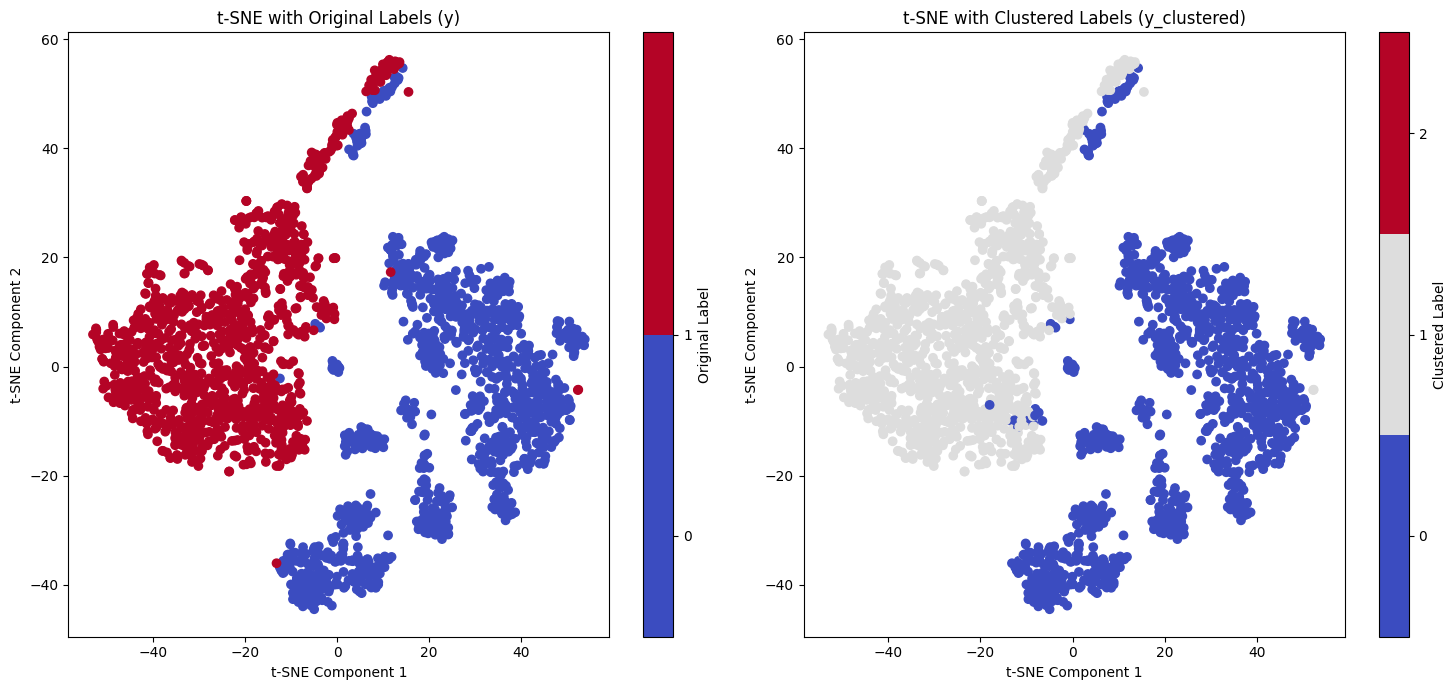

In [15]:
try:
    plot_tsne(X, y, y_clustered)

except NameError:
    print("Variable 'y' or 'y_clustered' is not defined.")

### Plot on map: `ID` and `WILD` labels

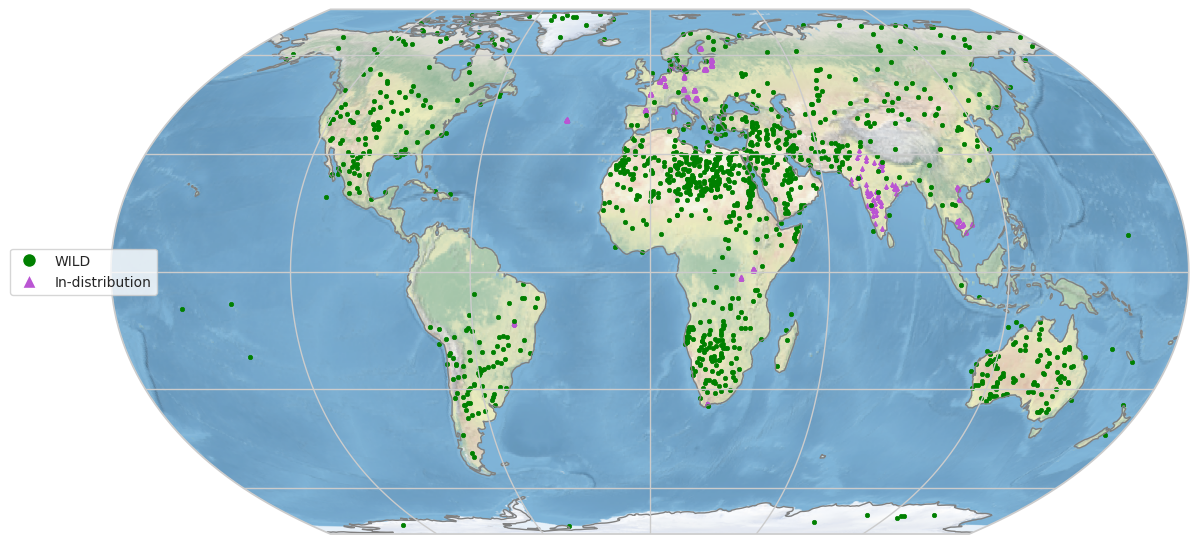

In [16]:
plot_ID_WILD(
    ID_all,
    WILD_all,
    save=True,
    file_format="png",
    dpi=100,
    filepath="./plots",
    filename="on_map_id_wild",
)

### Plot on map: `ID` and `WILD` breakdown into `surrogate ID` and `surrogate OOD` labels

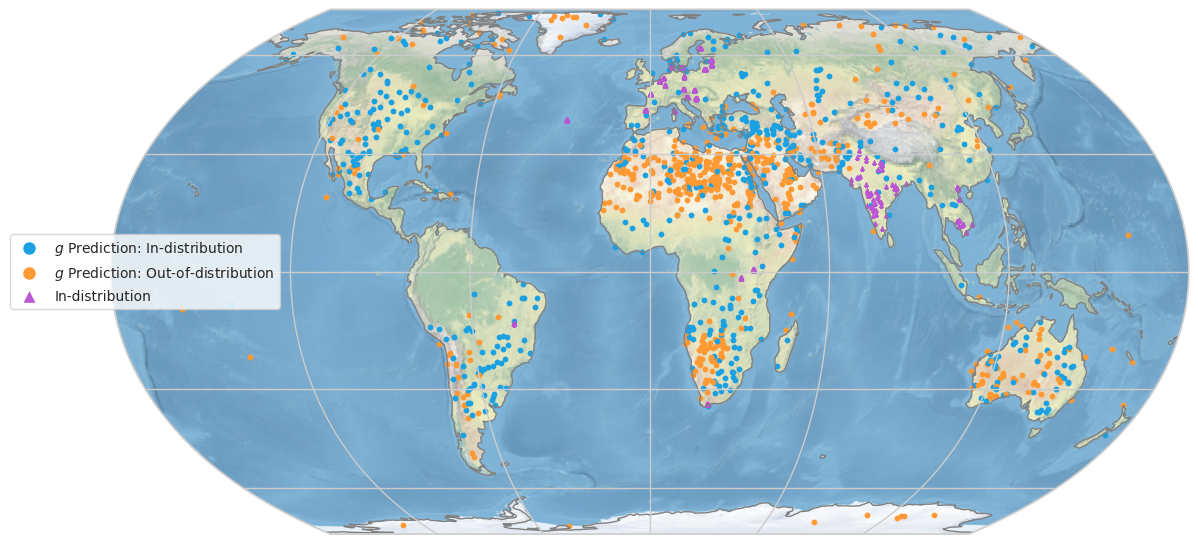

In [17]:
plot_ID_surrID_surrOOD(
    WILD_all,
    ID_all,
    save=True,
    file_format="png",
    dpi=100,
    filepath="./plots",
    filename="on_map_id_surrID_surrOOD",
)

### `g(WILD)` probabilities in a histogram

Skewness of g_pred over WILD data -0.003158858194410186


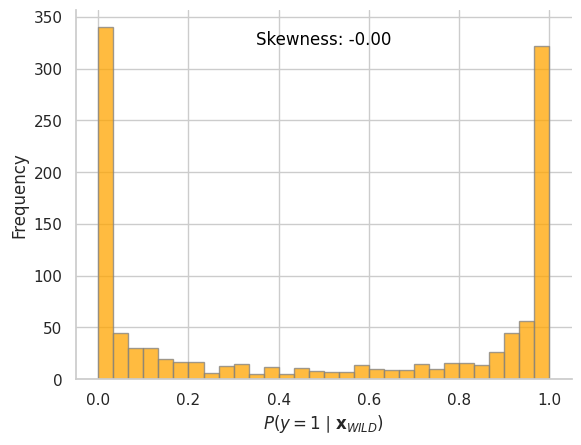

In [18]:
skew_prob = skew(WILD_all["g_pred_probs"])
print("Skewness of g_pred over WILD data", skew_prob)

plot_g_prob_distribution_w_skewness(
    WILD_all["g_pred_probs"], suffix="WILD", skewness_value=skew_prob, save_plot=True
)

### For each train sample in FTW, compute the `f` and `g` predictions

In [19]:
dataloader_factory = {}
max_batches = 5 # Set to `None` to use all available data
batch_size = 1

for country in all_countries:
    FTWDatamoduleOOD = FTWDataModuleOOD(
        root_folder_torchgeo,
        batch_size=batch_size,
        num_workers=num_workers,
        train_countries=None,
        val_countries=None,
        test_countries=country,
        download=False,
        sample_N_from_each_country=sample_N_from_each_country,
        target=target,
    )

    FTWDatamoduleOOD.setup(stage="test")
    test_dataloader = FTWDatamoduleOOD.test_dataloader()
    dataloader_factory[country] = test_dataloader

country_results = {}
metrics_dict = {}

for country in tqdm.tqdm(all_countries):
    print("Country:", country)

    testset_id_dataloader = dataloader_factory[country]

    return_f_pred = True
    return_g_pred = True
    return_thresholded_g_pred = False
    return_coords = False
    return_masks = True
    upsample = True
    max_batches = max_batches

    ID_all = process_ID_dataloader(
        testset_id_dataloader,
        ood_model,
        return_f_pred=return_f_pred,
        return_g_pred=return_g_pred,
        return_thresholded_g_pred=return_thresholded_g_pred,
        return_coords=return_coords,
        return_masks=return_masks,
        upsample=upsample,
        max_batches=max_batches,
    )

    f_preds_single_channel = ID_all["f_preds"]
    g_pred_probs_testsetid = ID_all["g_pred_probs"]
    true_masks_all = ID_all["masks"]

    metrics = calculate_metrics(true_masks_all, f_preds_single_channel)

    country_results[country] = {
        "f_preds_testsetid": f_preds_single_channel,
        "g_pred_probs_testsetid": g_pred_probs_testsetid,
        "true_masks": true_masks_all,
        "metrics": metrics,
    }

    # Clean up
    del f_preds_single_channel, g_pred_probs_testsetid, true_masks_all
    torch.cuda.empty_cache()

Loaded datamodule with:
Train countries: None
Val countries: None
Test countries: belgium
Test dataset: 50 for the countries belgium
Loaded datamodule with:
Train countries: None
Val countries: None
Test countries: cambodia
Test dataset: 25 for the countries cambodia
Loaded datamodule with:
Train countries: None
Val countries: None
Test countries: croatia
Test dataset: 50 for the countries croatia
Loaded datamodule with:
Train countries: None
Val countries: None
Test countries: estonia
Test dataset: 50 for the countries estonia
Loaded datamodule with:
Train countries: None
Val countries: None
Test countries: portugal
Test dataset: 10 for the countries portugal
Loaded datamodule with:
Train countries: None
Val countries: None
Test countries: slovakia
Test dataset: 50 for the countries slovakia
Loaded datamodule with:
Train countries: None
Val countries: None
Test countries: south_africa
Test dataset: 50 for the countries south_africa
Loaded datamodule with:
Train countries: None
Val cou

  0%|          | 0/25 [00:00<?, ?it/s]

Country: belgium



  4%|▍         | 1/25 [00:12<05:03, 12.64s/it]

Country: cambodia



  8%|▊         | 2/25 [00:25<04:48, 12.53s/it]

Country: croatia



 12%|█▏        | 3/25 [00:37<04:39, 12.70s/it]

Country: estonia



 16%|█▌        | 4/25 [00:50<04:27, 12.73s/it]

Country: portugal



 20%|██        | 5/25 [01:03<04:13, 12.70s/it]

Country: slovakia



 24%|██▍       | 6/25 [01:16<04:01, 12.69s/it]

Country: south_africa



 28%|██▊       | 7/25 [01:28<03:49, 12.73s/it]

Country: sweden



 32%|███▏      | 8/25 [01:41<03:37, 12.79s/it]

Country: austria



 36%|███▌      | 9/25 [01:54<03:23, 12.74s/it]

Country: brazil



 40%|████      | 10/25 [02:06<03:10, 12.68s/it]

Country: corsica



 44%|████▍     | 11/25 [02:19<02:58, 12.76s/it]

Country: denmark



 48%|████▊     | 12/25 [02:32<02:45, 12.76s/it]

Country: france



 52%|█████▏    | 13/25 [02:45<02:33, 12.83s/it]

Country: india



 56%|█████▌    | 14/25 [02:58<02:20, 12.79s/it]

Country: latvia



 60%|██████    | 15/25 [03:11<02:07, 12.80s/it]

Country: luxembourg



 64%|██████▍   | 16/25 [03:24<01:55, 12.84s/it]

Country: finland



 68%|██████▊   | 17/25 [03:37<01:42, 12.86s/it]

Country: germany



 72%|███████▏  | 18/25 [03:49<01:29, 12.83s/it]

Country: kenya



 76%|███████▌  | 19/25 [04:02<01:16, 12.80s/it]

Country: lithuania



 80%|████████  | 20/25 [04:15<01:04, 12.83s/it]

Country: netherlands



 84%|████████▍ | 21/25 [04:28<00:51, 12.82s/it]

Country: rwanda



 88%|████████▊ | 22/25 [04:40<00:38, 12.79s/it]

Country: slovenia



 92%|█████████▏| 23/25 [04:53<00:25, 12.78s/it]

Country: spain



 96%|█████████▌| 24/25 [05:06<00:12, 12.76s/it]

Country: vietnam



100%|██████████| 25/25 [05:18<00:00, 12.76s/it]


Country: belgium
Country: cambodia
Country: croatia
Country: estonia
Country: portugal
Country: slovakia
Country: south_africa
Country: sweden
Country: austria
Country: brazil
Country: corsica
Country: denmark
Country: france
Country: india
Country: latvia
Country: luxembourg
Country: finland
Country: germany
Country: kenya
Country: lithuania
Country: netherlands
Country: rwanda
Country: slovenia
Country: spain
Country: vietnam


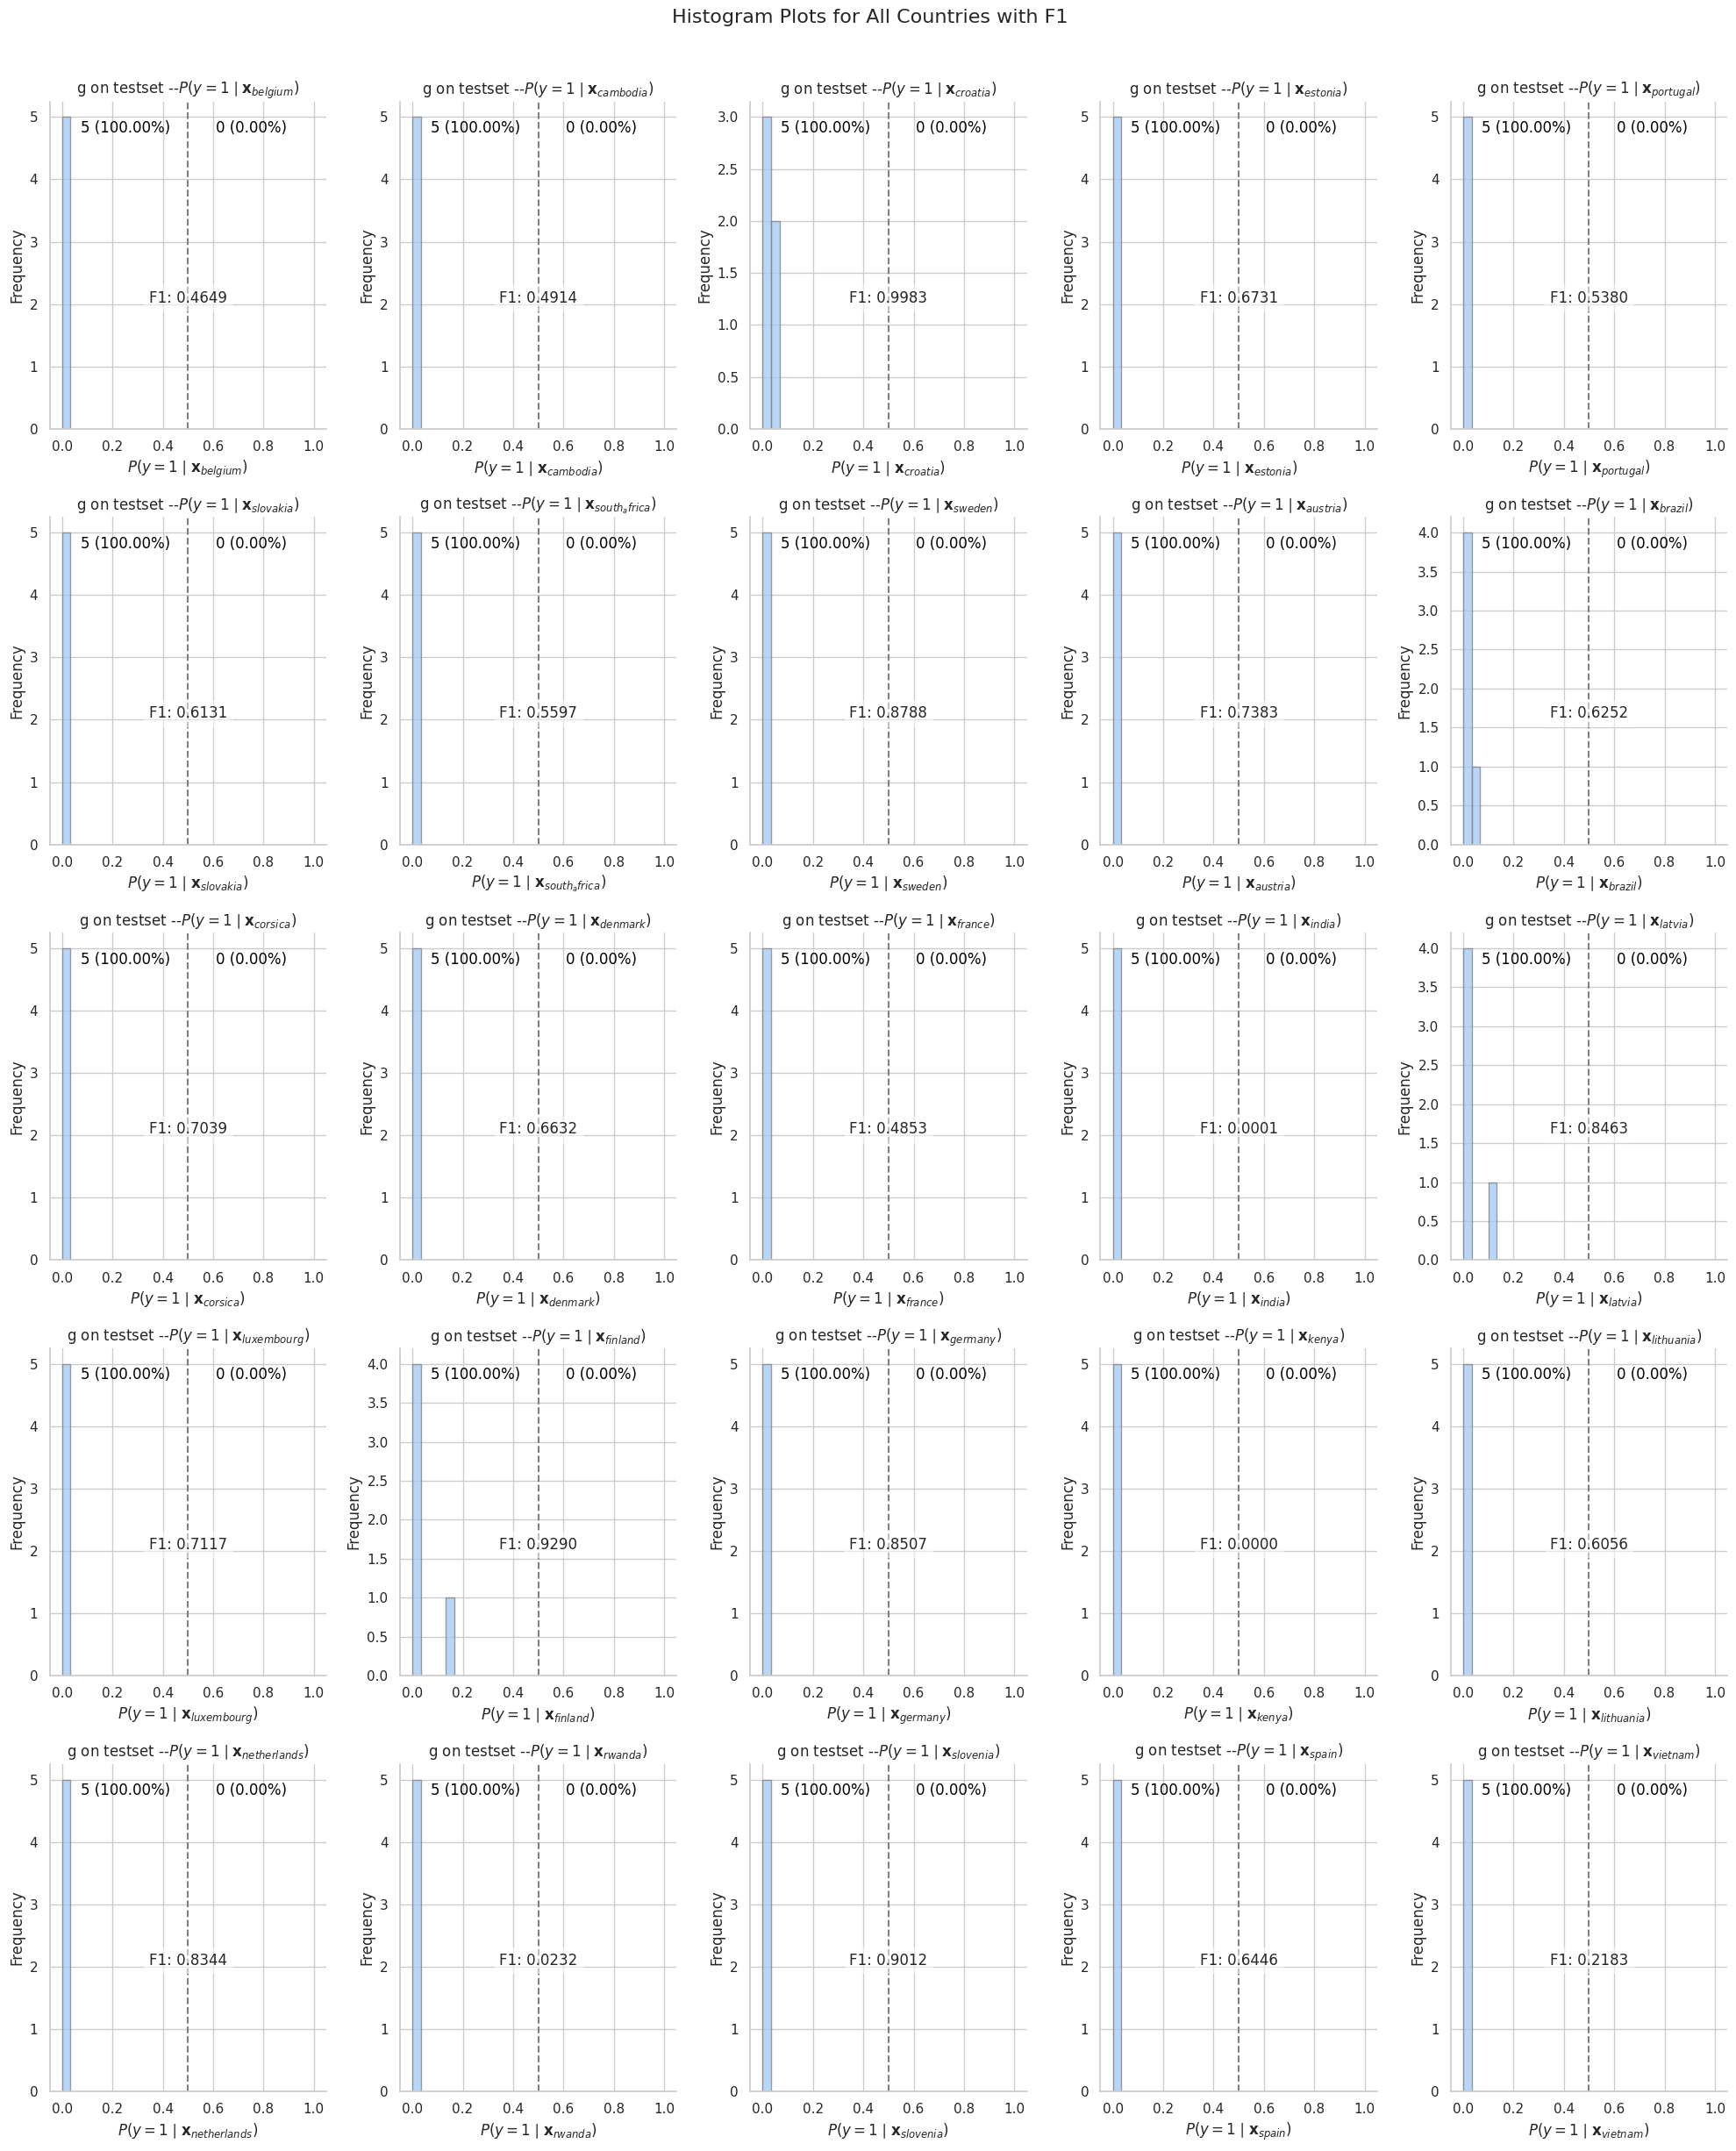

In [20]:
plot_histograms_for_countries(country_results, metric="f1")

F1 score vs. OOD score probability plot

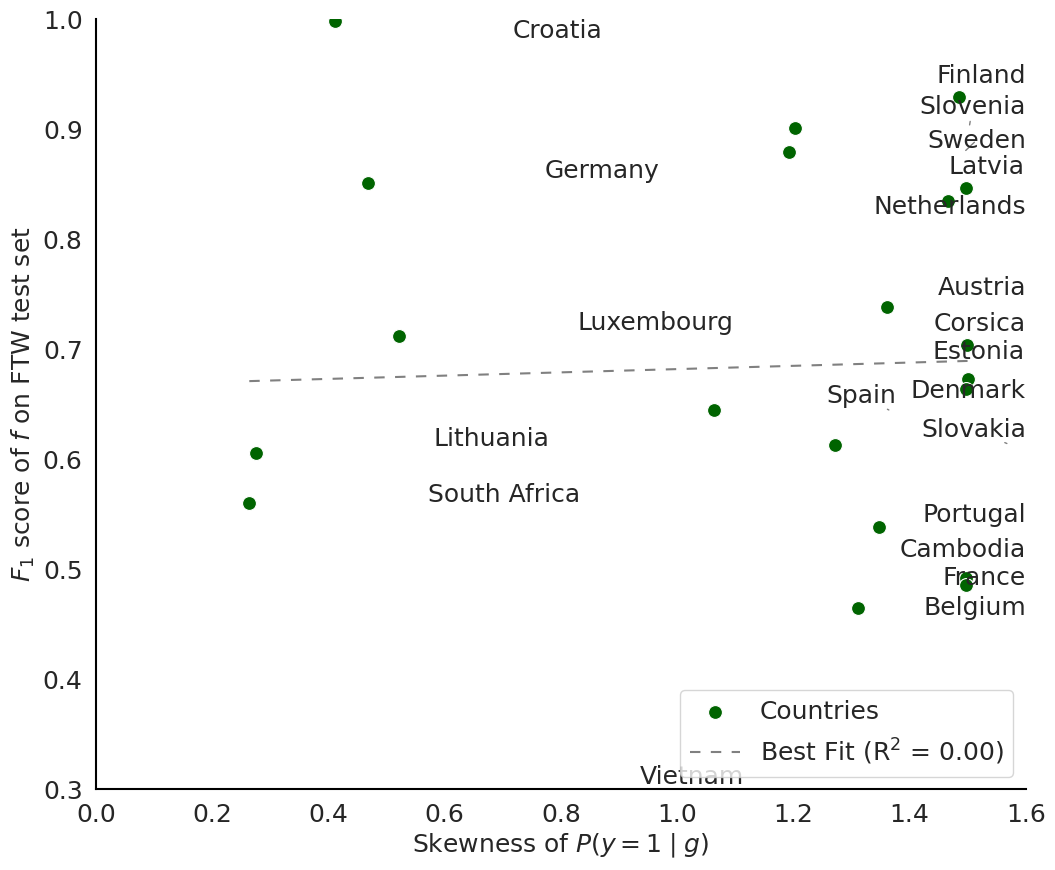

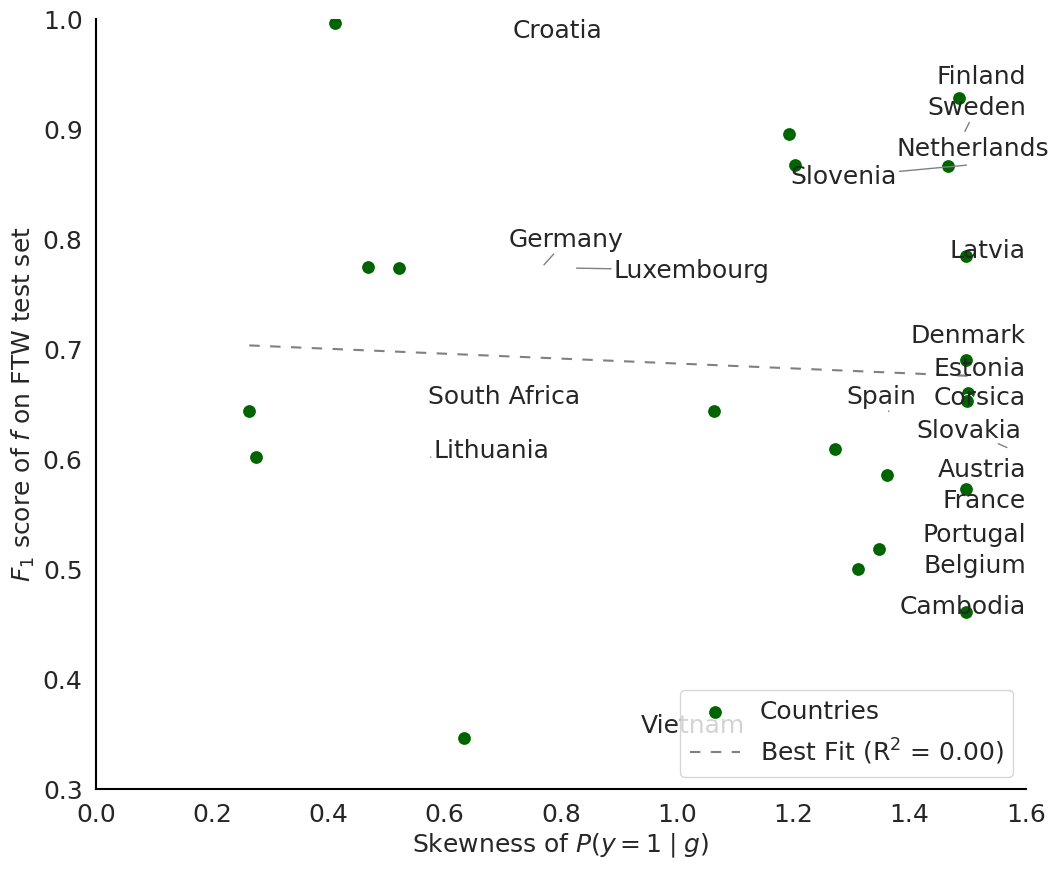

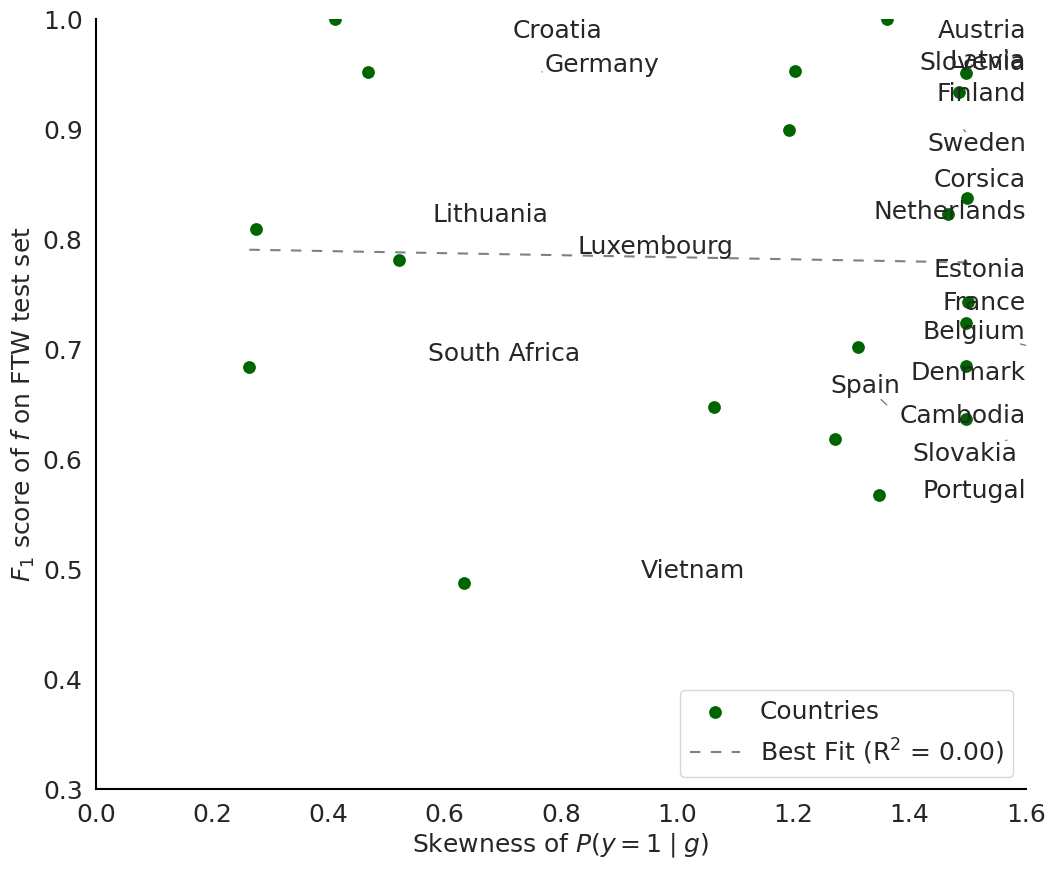

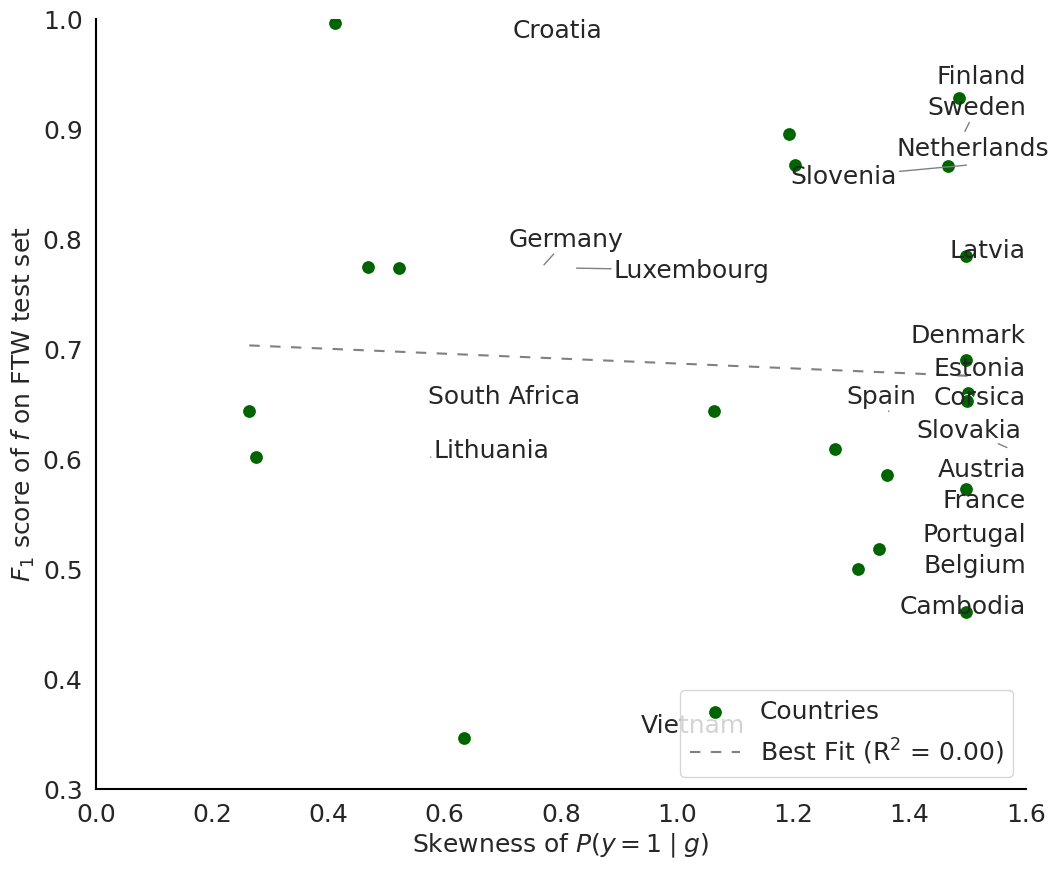

In [21]:
df = extract_data(country_results)

df["country"] = df["country"].str.strip().str.lower()

countries_to_remove = ["rwanda", "kenya", "india", "brazil"]
df = df[~df["country"].isin(countries_to_remove)]

df["country"] = df["country"].str.replace("_", " ").str.title()

df = df.reset_index(drop=True)

plot_ftwtest_f1_skew_r2(df, save_plot=True)

### Lowest, mid and top 10 percentiles of `g` predictions with their corresponding input images and `f` preds

In [22]:
# Sort the array and get the corresponding indexes
sorted_indexes = np.argsort(WILD_all["g_pred_probs"])

# Determine the percentile ranges
n = len(WILD_all["g_pred_probs"])
lowest_10_percentile_indexes = sorted_indexes[: int(0.1 * n)]
mid_10_percentile_start = int(0.45 * n)
mid_10_percentile_end = int(0.55 * n)
mid_10_percentile_indexes = sorted_indexes[
    mid_10_percentile_start:mid_10_percentile_end
]
top_10_percentile_indexes = sorted_indexes[-int(0.1 * n) :]

print("Indexes of the lowest 10 percentile values:", lowest_10_percentile_indexes)
print("Indexes of the middle 10 percentile values:", mid_10_percentile_indexes)
print("Indexes of the top 10 percentile values:", top_10_percentile_indexes)

Indexes of the lowest 10 percentile values: [1100 1128   68  421  478  407  415   21  321 1147 1037  837  517  618
   87  625  461  608  802  735  212  706  172   65 1059 1116 1033   74
  247  910  985  755   98 1002  186  265  797  920  137  158  854  989
 1076  490  192  745  376  945  157  242  223  692  175  448   91  392
   78  806  385 1008  850  808   43  576  617  451  291  191  452  123
  178 1108  681  796 1043  787  357  466  966  106  655  697 1045  480
  963 1090  244  841  318  545  537   75  174  262  536   51    0  411
  522  909  458 1073  422  455  111 1040  573  462 1127  779 1023   89
  621  271  592]
Indexes of the middle 10 percentile values: [1030  847  529  190  996  185  473  329  662  225  838  105   37  953
   19  563  652 1093  896  406 1055  669  810  967  670  892  580  203
  505  317  763 1089  284   64  596 1003  842  751 1095  283   85  800
  778  918   31  315  180  374  955  868  163  746  232  782  948  241
   59  626  609  969  768  927   10  369  5

OOD Score 2.901618488942838e-05


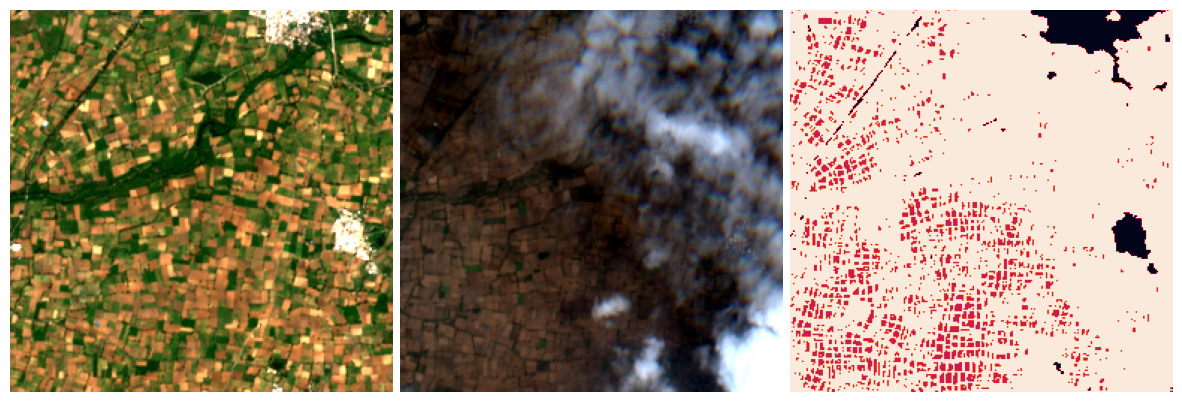

In [29]:
idx = np.random.choice(lowest_10_percentile_indexes)
coord = WILD_all["coords"][idx]
g_pred_prob_wild = WILD_all["g_pred_probs"][idx]

window_a = percentile_stretch(WILD_all["batch"][idx, :3, :, :].permute(1, 2, 0))
window_b = percentile_stretch(WILD_all["batch"][idx, 4:-1, :, :].permute(1, 2, 0))

f_pred_permuted = WILD_all["f_preds"][idx]

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
fname = f"{g_pred_prob_wild}_WILD_{idx}_{timestamp}.png"
print("OOD Score", g_pred_prob_wild)
plot_f_and_g_preds_probab(window_a, window_b, g_pred_prob_wild, f_pred_permuted)

Save them all

In [ ]:
percentiles_dict = {
    "lowest_10": lowest_10_percentile_indexes,
    "mid_10": mid_10_percentile_indexes,
    "top_10": top_10_percentile_indexes,
}

num_samples_to_process = len(percentiles_dict["lowest_10"])

for perc_name, percentile_idx in percentiles_dict.items():
    sample_count = 0
    for idx in percentile_idx:
        if sample_count >= num_samples_to_process:
            break

        coord = WILD_all["coords"][idx]
        g_pred_prob_wild = WILD_all["g_pred_probs"][idx]

        window_a = percentile_stretch(WILD_all["batch"][idx, :3, :, :].permute(1, 2, 0))
        window_b = percentile_stretch(
            WILD_all["batch"][idx, 4:-1, :, :].permute(1, 2, 0)
        )

        f_pred_permuted = WILD_all["f_preds"][idx]

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        fname = f"{perc_name}_{g_pred_prob_wild}_WILD_{idx}_{timestamp}.png"

        plot_f_and_g_preds_probab(
            window_a,
            window_b,
            g_pred_prob_wild,
            f_pred_permuted,
            "./preds_percentile",
            fname,
        )

        sample_count += 1